In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate, RepeatedStratifiedKFold, cross_val_score
from scipy.stats import randint
from statistics import mean
from imblearn.over_sampling import BorderlineSMOTE, SMOTE

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [88]:
# Read in data
df = pd.read_excel('Data.xlsx', [1]).get(1)

In [101]:
# Drop redundant columns and those with high NaN counts
df2 = df.drop(columns=[
    'BiomeEncounterID', 'VisitId', 'TotalCost', 'DirectCost', 
    'ProcedureRelatedDirectCost', 'SyntaxScore', 'Mortality',
    'InsurancePayerManagedCare',
    'InsurancePayerMedicareTraditional', 'InsurancePayerMedicareRisk',
    'InsurancePayerSelfPayUnmapped', 'InsurancePayerMedicaidTraditional',
    'InsurancePayerOther', 'InsurancePayerMedicaidRisk',
    'InsurancePayerManagedMedicare', 'InsurancePayerMedicare',
    'InsurancePayerCommercial', 'InsurancePayerMedicaid',
    'InsurancePayerManagedMedicaid', 'InsurancePayerSelfPay',
    'InsurancePayerWorkersCompensation', 'InsurancePayerPayorNotProvided',
    'FullMortalityRisk', 'HospitalSystem', 'PrePCILVEF', 'MVSupport', 'Quarter',
    'ProceduralistNPI', 'RadialAccess', 'RaceUnknown', 'RaceUnknown', 'IndicationOther', 'CTO'
])
df2 = df2.fillna({    # Fill rest of NaNs with either specific values or mode of column
    'StrokeUndetermined': 'Yes',
    'Distance': df2['Distance'].mean()
}).fillna(df2.mode().to_dict('records')[0]).replace(['Yes', 'No'], [1,0]) # Replace Yes/No with binary value

In [103]:
df2.groupby('Hospital')['ImpellaFlag'].mean()

Hospital
ABSMC      0.024590
BJH        0.035326
CPMC       0.051963
CRMC       0.024958
ECH        0.016109
MGMC       0.020408
MMC        0.008965
MPMC       0.058081
RWJUH      0.027107
SDMC       0.000000
SMCS       0.022564
SRMC       0.011949
SSRRH      0.046980
UCD        0.035637
UCI        0.049724
UCLA-RR    0.040984
UCLA-SM    0.016949
UCSD       0.035573
UCSF       0.053922
Name: ImpellaFlag, dtype: float64

In [90]:
# Replace PatientZip with mode of zip grouped by Hospital, fix leading 0 issue with integer cast
dfz = df2[df2['PatientZip'] != 0].groupby('Hospital')['PatientZip'].agg(pd.Series.mode)
dfz['UCSF'] = dfz['UCSF'][0]
dfz = dfz.reset_index().rename(columns={"PatientZip": "zipMode"})
df2 = df2.merge(dfz, on='Hospital')
df2['PatientZip'] = np.where(df2['PatientZip'] == 0, df2['zipMode'], df2['PatientZip']).astype(int)
df2 = df2.drop(columns='zipMode')

In [91]:
from pprint import pprint
pprint(df2.columns)

Index(['Procedure', 'ImpellaFlag', 'HighRisk? (EF, Mortality)', 'Distance',
       'PatientZip', 'Hospital', 'AdmissionDayOfWeek', 'Age', 'Gender',
       'RaceBlack', 'RaceHispanic', 'RaceWhite', 'RaceOther',
       'SummaryPayorClass', 'HxDiabetes', 'HxDyslipidemia', 'HxHypertension',
       'HxTobaccoUse', 'HxHF', 'ProcedureMedicationG2B2A',
       'ProcedureMedicationBivalirudin', 'ProcedureMedicationHeparin',
       'ProcedureMedicationPrasugrel', 'ProcedureMedicationTicagrelor',
       'ProcedureMedicationNovelOralAnticoagulant',
       'ProcedureMedicationWarfarin', 'MultiVesselDisease', 'AccessSite',
       'BifurcationLesion', 'BareMetalStentUsed', 'CAOutHospital',
       'CardiacArrestReasonForDelay', 'CardiogenicShock',
       'IndicationNSTEMIUnstableAngina', 'IndicationSTEMI', 'BleedingEventYN',
       'StrokeYN', 'PostHemStroke', 'StrokeIschemic', 'StrokeUndetermined',
       'LOS', 'ICUDays'],
      dtype='object')


In [84]:
df2['Distance'].median()

14.91

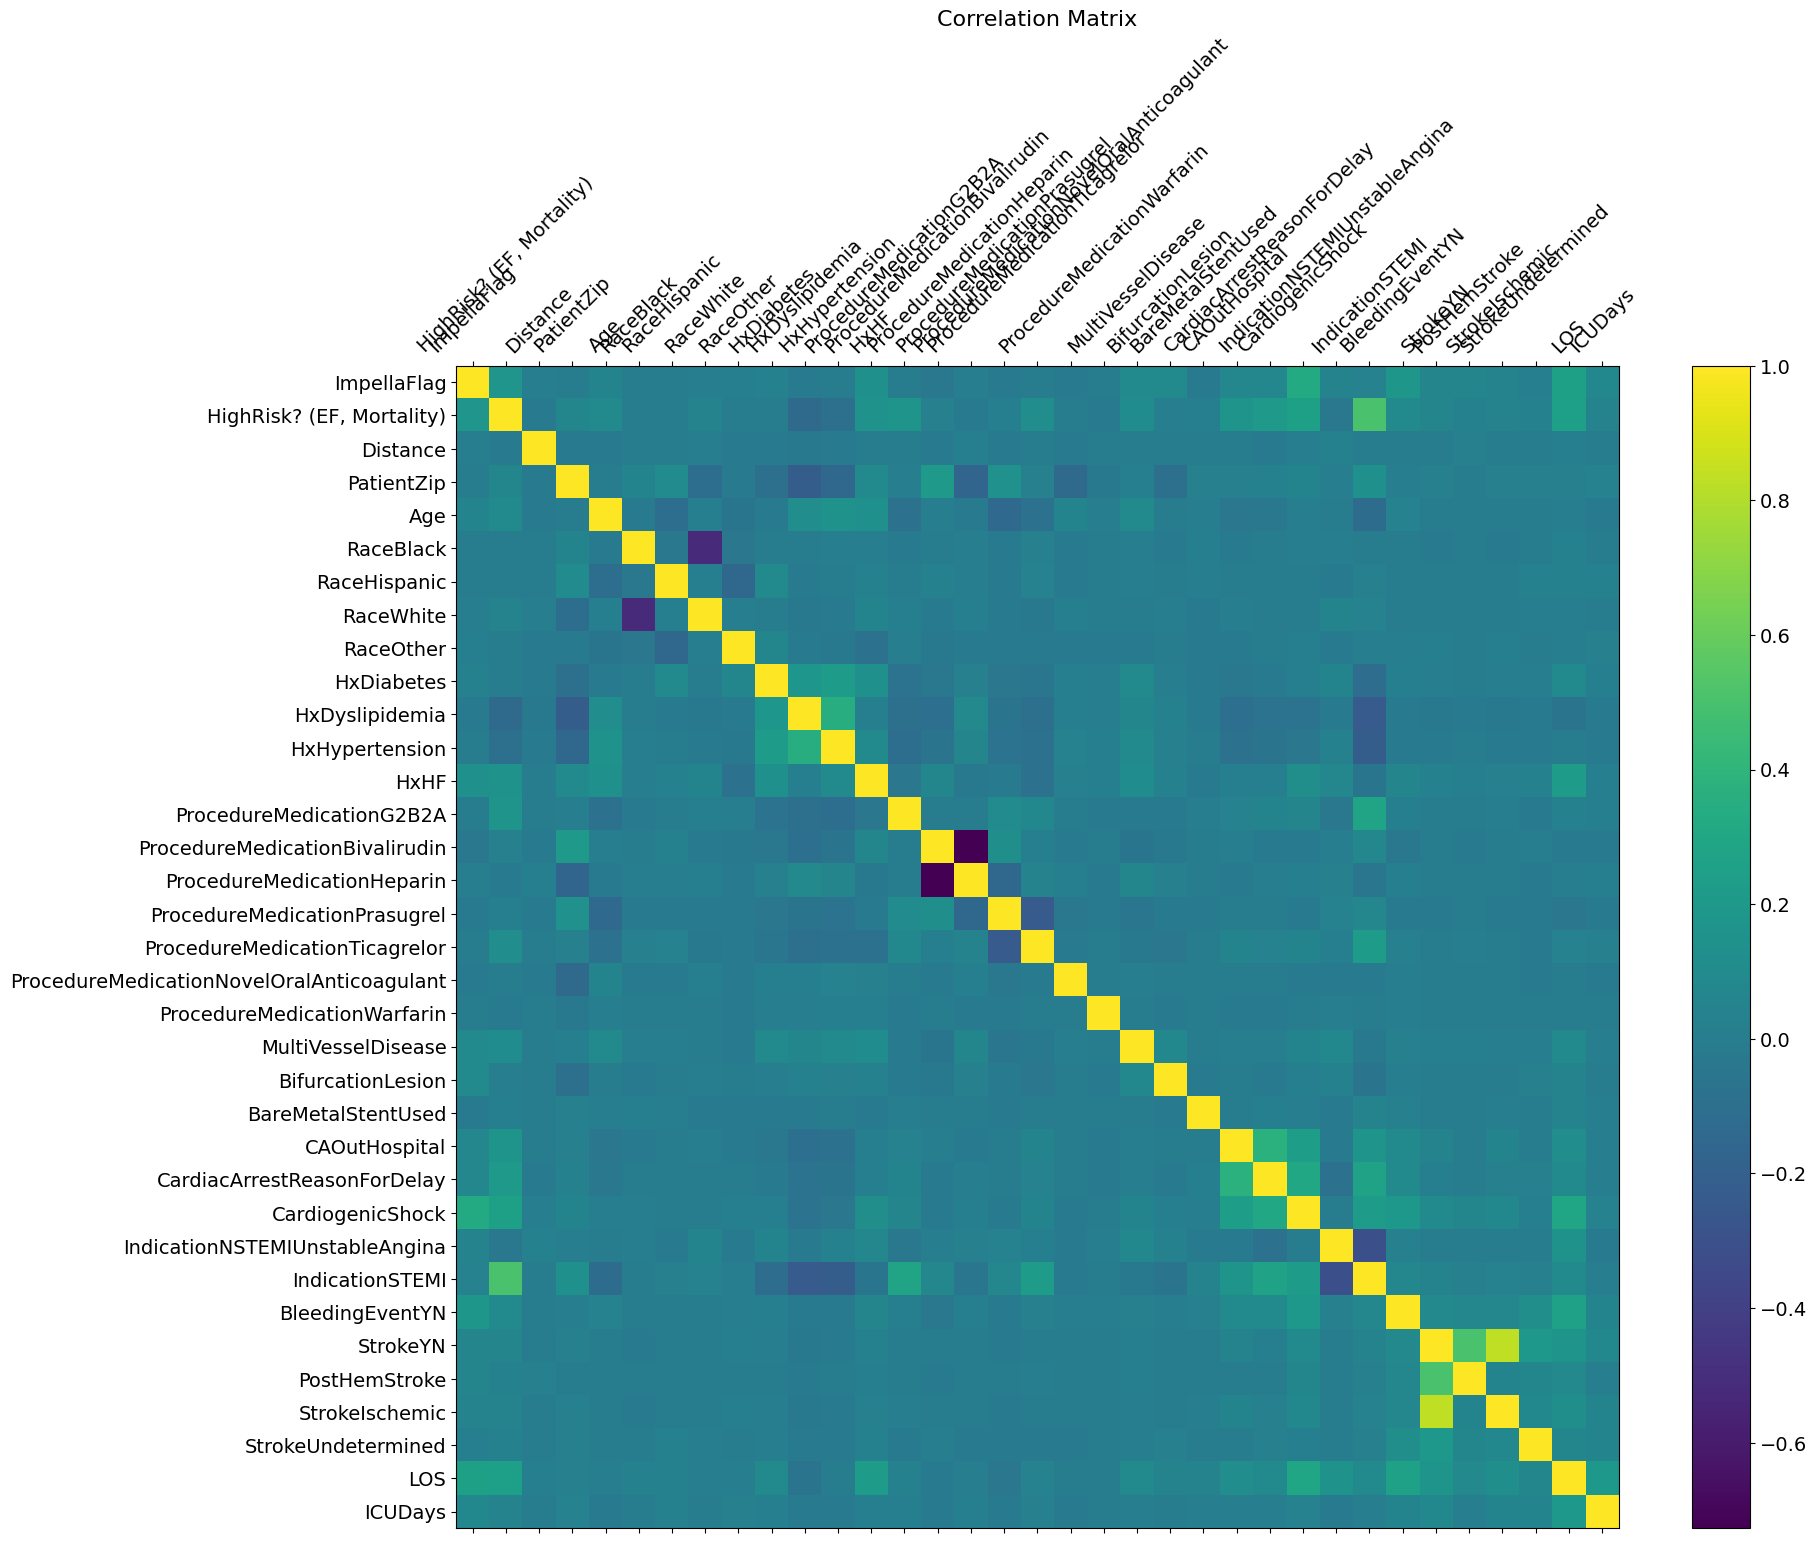

In [92]:
# Plot correlation matrix for numerical columns
dfnum = df2.select_dtypes(include=np.number)
f = plt.figure(figsize=(19, 15))
plt.matshow(dfnum.corr(), fignum=f.number)
plt.xticks(range(dfnum.shape[1]), dfnum.columns, fontsize=14, rotation=45)
plt.yticks(range(dfnum.shape[1]), dfnum.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [93]:
# One-hot keying categorical variables
dfstr = df2.select_dtypes(exclude=['int64', 'float64'])
df2 = pd.concat([df2, pd.get_dummies(dfstr).astype(int)], axis=1)
df2 = df2.drop(columns = dfstr.columns)

In [98]:
df2.Hospital.value_counts()

AttributeError: 'DataFrame' object has no attribute 'Hospital'

In [94]:
# Split the data into features (X) and target (y)
X = df2.drop('ImpellaFlag', axis=1)
y = df2['ImpellaFlag']

Best hyperparameters: {'max_depth': 16, 'n_estimators': 379}
Accuracy: 0.9703107658157603


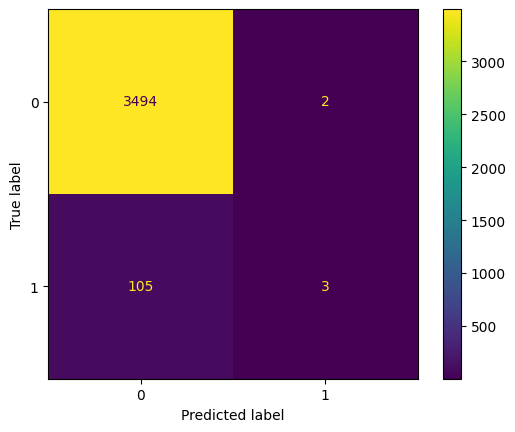

In [95]:
# Random Forest
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(
    rf, 
    param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}, 
    n_iter=5, 
    cv=5
)


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

rand_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = rand_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [97]:
df2.columns

Index(['ImpellaFlag', 'HighRisk? (EF, Mortality)', 'Distance', 'PatientZip',
       'Age', 'RaceBlack', 'RaceHispanic', 'RaceWhite', 'RaceOther',
       'HxDiabetes',
       ...
       'HxTobaccoUse_Current - Some Days', 'HxTobaccoUse_Former',
       'HxTobaccoUse_Never', 'HxTobaccoUse_Smoker - Current status unknown',
       'HxTobaccoUse_Unknown if ever smoked', 'AccessSite_Brachial',
       'AccessSite_Femoral', 'AccessSite_Other', 'AccessSite_Radial',
       'AccessSite_Unrecorded'],
      dtype='object', length=142)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 361}
Accuracy: 0.9913984461709212


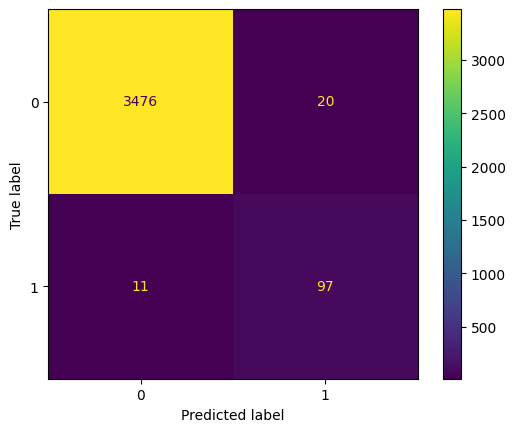

In [99]:
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.2, stratify=over_y)

# Retrain using SMOTE
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(
    rf, 
    param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}, 
    n_iter=5, 
    cv=5
)

rand_search.fit(over_X_train, over_y_train)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

SMOTE_SRF = RandomForestClassifier(
    n_estimators=rand_search.best_params_['n_estimators'],
    max_depth = rand_search.best_params_['max_depth'],
    random_state=0
)
#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

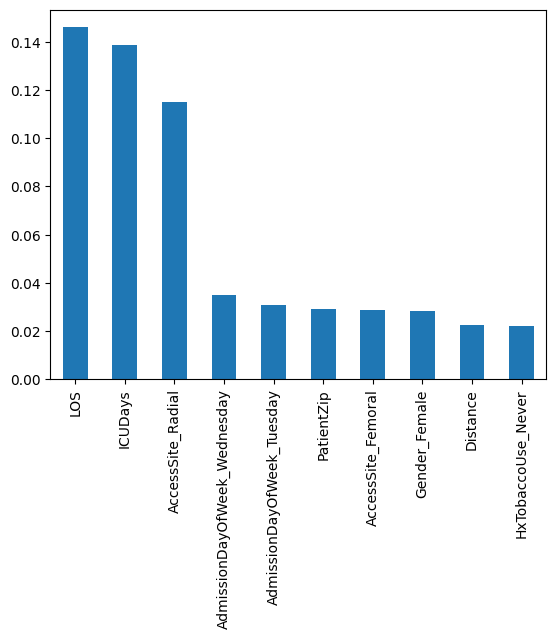

In [100]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(SMOTE_SRF.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)

# Plot a simple bar chart
feature_importances.plot.bar();

/usr/local/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9700332963374029


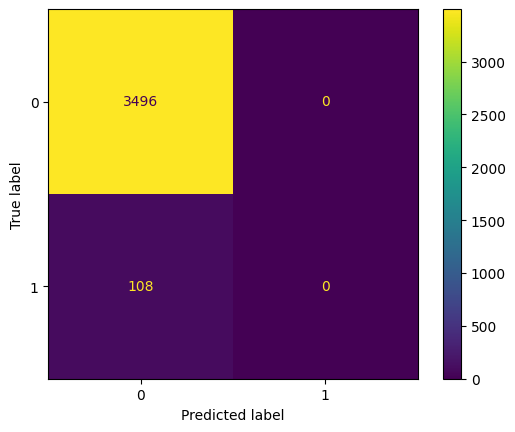

In [11]:
# Train KNN Model
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_scaled, y, cv=5)
    scores.append(np.mean(score))

best_index = np.argmax(scores)
best_k = k_values[best_index]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(over_X_train, over_y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [12]:
best_k

26

Accuracy: 0.9309100998890122


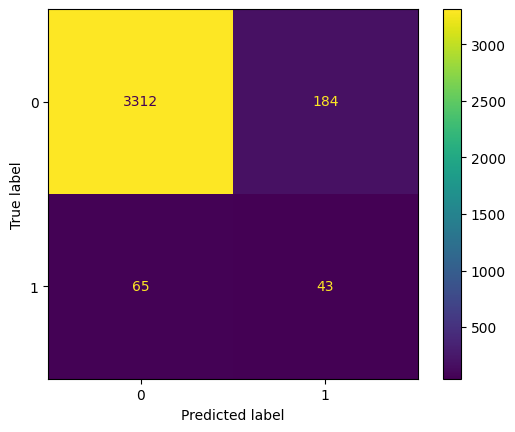

In [13]:
# Train NB model
nb = GaussianNB()
nb.fit(over_X_train, over_y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
y_pred = nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();